### RAG
RAG - Retrieval-Augmented Generation это подход, основанный на промптах, который позволяет дообучить модель на своих данных (на самом деле не совсем). Здесь мы не используем огромные вычислительные ресурсы и объемные датасеты

Концептуально это выглядит так:
- формируется промпт с запросом
- система ищет документы в заранее сформированной базе знаний, которые нужны для релевантного ответа
- в промпт в качестве контекста добавляются нужные доки
- готовый промпт с инструкциями отправляется в llm
- llm генерит ответ

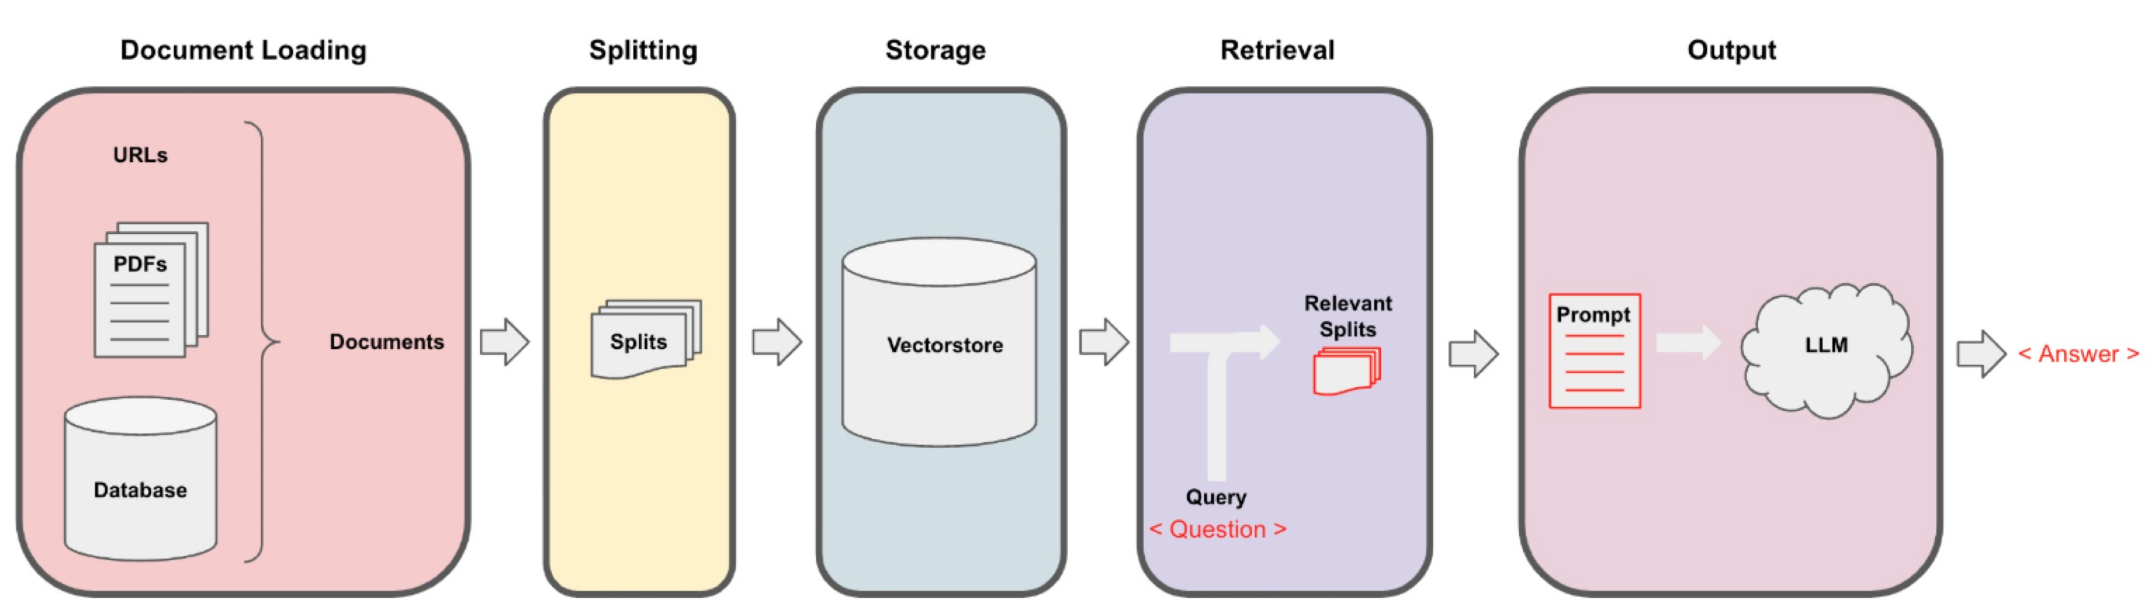

In [1]:
import os
from getpass import getpass
from langchain_openai import ChatOpenAI

# course_api_key= "Введите ваш ключ, полученный в боте курса"
course_api_key = getpass(prompt="Введите ваш ключ, полученный в боте курса")

# инициализируем языковую модель
llm = ChatOpenAI(api_key=course_api_key, model='gpt-4o-mini', 
                 base_url="https://aleron-llm.neuraldeep.tech/")

### Document loader

В Langchain есть много разных оберток для загрузки из различных источников и типов файлов
Если же данные уже в текстовых файлах - можно ими не пользоваться, НО следи чтобы в них:
- не было ненужных артефактов

Здесь смотрим:
- Dataframe loader
- cvs loader

In [3]:
import pandas as pd
from langchain.document_loaders import CSVLoader, DataFrameLoader

doc = pd.read_csv("../../data/Data.csv")
doc.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\n,I loved this product. But they only seem to l...


In [ ]:
#Создаем датафрейм лоадер
loader = DataFrameLoader(doc, page_content_column="Review") #Укажи колонку в которой контент
document = loader.load()

print(f'Тип: {type(document)}. Тип содержимого: {type(document[0])}')
print(f'\nСодержимое:{document[0]}')

#Внутри метадата (другие колонки) и контент

Тип: <class 'list'>. Тип содержимого: <class 'langchain_core.documents.base.Document'>

Содержимое:page_content='I ordered a king size set. My only criticism would be that I wish seller would offer the king size set with 4 pillowcases. I separately ordered a two pack of pillowcases so I could have a total of four. When I saw the two packages, it looked like the color did not exactly match. Customer service was excellent about sending me two more pillowcases so I would have four that matched. Excellent! For the cost of these sheets, I am satisfied with the characteristics and coolness of the sheets.' metadata={'Product': 'Queen Size Sheet Set'}


In [10]:
# Теперь воспользуемся CSV лоадером
loader = CSVLoader(file_path="../../data/Data.csv")

documents = loader.load()
documents[0]

Document(metadata={'source': '../../data/Data.csv', 'row': 0}, page_content='Product: Queen Size Sheet Set\nReview: I ordered a king size set. My only criticism would be that I wish seller would offer the king size set with 4 pillowcases. I separately ordered a two pack of pillowcases so I could have a total of four. When I saw the two packages, it looked like the color did not exactly match. Customer service was excellent about sending me two more pillowcases so I would have four that matched. Excellent! For the cost of these sheets, I am satisfied with the characteristics and coolness of the sheets.')

In [ ]:
#DirectoryLoader
from langchain_community.document_loaders import DirectoryLoader

#Установи pip3 install unstructured
loader = DirectoryLoader('../../data/',glob="**/*.txt")

documents = loader.load()
documents[0]

#Document(metadata={'source': '..\\..\\data\\dir_loader_1.txt'}, page_content='Здесь находится какая то информация')

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


Document(metadata={'source': '..\\..\\data\\dir_loader_1.txt'}, page_content='Здесь находится какая то информация')

### Text Splitter
После получения текстовых данных из файлов нужно разделить их на отдельные отрывки (документы)

Требования к разбивке:
- разбивка должна быть логичной и содержать законченную мысль (абзац книги или статья закона)
- документы не должны быть огромного размера, чтобы влезть в контекстное окно модели

!!От правильного сплиттинга зависит качество
Сплиттеры тут - https://python.langchain.com/docs/how_to/#text-splitters
  

In [16]:
#Загружаем свой текстовый файл с PEP8

with open("../../data/PEP8.txt",encoding='utf-8',mode='r') as file:
    doc = file.read()

print(f"Тип {type(doc)}")

Тип <class 'str'>


In [ ]:
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter

splitter = CharacterTextSplitter(
    separator="\n\n",  # символ-разделитель, по умолчанию переход к новому абзацу '\n\n'
    chunk_size=500,  # размер документа в символах
    chunk_overlap=100,  # насколько соседние документы могут перекрывать друг-друга
    length_function=len,  # функция, по которой считается размер документа
    is_separator_regex=False,  # является ли разделитель регулярным выражением
)

split_documents = splitter.create_documents([doc])
len(split_documents)

#В данном случае мы получили 3 документа, которые не уместились в 500 символов, так как они вышли больше

Created a chunk of size 723, which is longer than the specified 500
Created a chunk of size 522, which is longer than the specified 500
Created a chunk of size 502, which is longer than the specified 500


132

In [19]:
#На помощь придет RecursiveCharacterTextSplitter, он:
# - проходит по тексту и бьет по сплиттеру
# - если не получилось - идет по предложениям (.) и так далее

splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
)
split_documents = splitter.create_documents([doc])
len(split_documents)

135

### Embedding models
Для того чтобы подать текст на вход нужно преобразовать тексты в векторную форму (эмбеддинги). Запрос тоже переводится
моделью в векторную форму и ищутся близкие вектора (референсы)

Доставать эмбеддинги можно двумя способами:
- по API (может выйти дорого по токенам)
- Локально развернув модель (нужен GPU)

Здесь сначала покажем эмбеддинги от вендоров

In [20]:
# Если используете ключ курса, запустите эту ячейку
from langchain_openai import OpenAIEmbeddings

embeddings_api_model = OpenAIEmbeddings(api_key=course_api_key, model='text-embedding-3-small', 
                                        base_url="https://aleron-llm.neuraldeep.tech/")

In [ ]:
#Создаем эмбеддинги
embeddings = embeddings_api_model.embed_documents(["Привет"
                                                   ,"Как дела"
                                                   ,"Это новый кадиллак"])

print(f'Размер эмбеддинга: {len(embeddings[0])}\nТип: {type(embeddings[0])}')

# Размер эмбеддинга: 1536
# Тип: <class 'list'>

#Эмбеддинг OpenAI представляет любой текст цифрами в количестве 1536

Размер эмбеддинга: 1536
Тип: <class 'list'>


### Локальный Embedding от HuggingFace
HuggingFace предоставляет много моделей для эмбеддинга бесплатно (экономия на токенах), но нужно разворачивать на своем железе


Для примера будем юзать - `"cointegrated/LaBSE-en-ru"`. Она неплохо работает и не оч требовательная

Что нужно учитывать:
- посчитай бюджет (лучше тратиться на токены или железо)
- размер эмбеддингов (сколько места будет занимать бд для хранения)
- длина и сложность документов (чем сложнее тексты и термины, тем больше размерность эмбеддингов нужна)
- тематика задач (модели по-разному справляются с разными темами)
- мультиязычность (чем больше языков, тем больше места будет занимать модель)

Рабочий кейс: ищи лидеров эмбеддингов и бери под свою задачу
https://huggingface.co/spaces/mteb/leaderboard

Ссылка на модели - https://huggingface.co/models


In [24]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import os

#Указываем заранее куда ставим
os.environ["HF_HOME"] = "D:\\Khabarov\Репозиторий\\huggingface_cache"  # Указываем диск D

#Установи pip3 install sentence-transformers
#Если видеокарта, укажи device: 'cuda'
hf_embeddings_model = HuggingFaceBgeEmbeddings(model_name="cointegrated/LaBSE-en-ru"
                                               ,model_kwargs={"device": "cpu"}
                                            #    ,model_kwargs={"device": "cuda"}
                                               )

embeddings = hf_embeddings_model.embed_documents(
    [
        "Привет!",
        "Hello World!",
        "How are you?",
    ]
)

### Vector Store
Теперь после создания эмбеддингов наша задача их эффективно хранить и проводить по ним поиск
Здесь можно использовать любую БД или специальное векторное хранилище

Основные решения такие:
- FAISS (от создателей концепции RAG)
- CHromaDB

In [27]:
from langchain.vectorstores import FAISS

#Создаем 
embeddings = OpenAIEmbeddings(api_key=course_api_key, model='text-embedding-3-small', 
                                        base_url="https://aleron-llm.neuraldeep.tech/")

#Здесь нужен #pip3 install faiss-gpu (если гпу)
#Или pip3 install faiss-cpu если CPU
db = FAISS.from_documents(
    split_documents[:70], embeddings
)  # создаём базу, возьмём первые 70 документов, чтобы тратить меньше токенов

db.save_local("faiss_db") #Сохраняем локально


In [ ]:
#Теперь можем делать запросы к базе
db.similarity_search("How many empty lines shuold be behind methods of a class?")

#Нашел 4 документа

[Document(id='9040edf8-1254-43ef-8bbd-7ea0c99417a3', metadata={}, page_content='Blank Lines\n-----------\n\nSurround top-level function and class definitions with two blank\nlines.\n\nMethod definitions inside a class are surrounded by a single blank\nline.\n\nExtra blank lines may be used (sparingly) to separate groups of\nrelated functions.  Blank lines may be omitted between a bunch of\nrelated one-liners (e.g. a set of dummy implementations).\n\nUse blank lines in functions, sparingly, to indicate logical sections.'),
 Document(id='715684df-164b-45bf-a6eb-6c62d2ae7017', metadata={}, page_content="3. Because the code in question predates the introduction of the\n   guideline and there is no other reason to be modifying that code.\n\n4. When the code needs to remain compatible with older versions of\n   Python that don't support the feature recommended by the style guide.\n\n\nCode Lay-out\n============\n\nIndentation\n-----------\n\nUse 4 spaces per indentation level."),
 Document(i

In [29]:
#Обрати внимание, что на русском и английском поиск происходит достаточно неплохо
# Также можно вывести скор каждого документа
db.similarity_search_with_score(
    "Сколько пустых строк нужно оставлять между методами класса?"
)[:2]

[(Document(id='9040edf8-1254-43ef-8bbd-7ea0c99417a3', metadata={}, page_content='Blank Lines\n-----------\n\nSurround top-level function and class definitions with two blank\nlines.\n\nMethod definitions inside a class are surrounded by a single blank\nline.\n\nExtra blank lines may be used (sparingly) to separate groups of\nrelated functions.  Blank lines may be omitted between a bunch of\nrelated one-liners (e.g. a set of dummy implementations).\n\nUse blank lines in functions, sparingly, to indicate logical sections.'),
  np.float32(1.0080206)),
 (Document(id='9a84e955-d5d4-4102-b4dc-ee51dd1c02fd', metadata={}, page_content='Some teams strongly prefer a longer line length.  For code maintained\nexclusively or primarily by a team that can reach agreement on this\nissue, it is okay to increase the line length limit up to 99 characters,\nprovided that comments and docstrings are still wrapped at 72\ncharacters.\n\nThe Python standard library is conservative and requires limiting\nlines

In [30]:
#А теперь русский
db.similarity_search_with_score(
    "How many empty lines shuold be behind methods of a class?"
)[:2]

[(Document(id='9040edf8-1254-43ef-8bbd-7ea0c99417a3', metadata={}, page_content='Blank Lines\n-----------\n\nSurround top-level function and class definitions with two blank\nlines.\n\nMethod definitions inside a class are surrounded by a single blank\nline.\n\nExtra blank lines may be used (sparingly) to separate groups of\nrelated functions.  Blank lines may be omitted between a bunch of\nrelated one-liners (e.g. a set of dummy implementations).\n\nUse blank lines in functions, sparingly, to indicate logical sections.'),
  np.float32(0.7374618)),
 (Document(id='715684df-164b-45bf-a6eb-6c62d2ae7017', metadata={}, page_content="3. Because the code in question predates the introduction of the\n   guideline and there is no other reason to be modifying that code.\n\n4. When the code needs to remain compatible with older versions of\n   Python that don't support the feature recommended by the style guide.\n\n\nCode Lay-out\n============\n\nIndentation\n-----------\n\nUse 4 spaces per inden

### Использование Retriever
Это такая надстройка над бд, которое может выдавать похожие документы, но не обязана их хранить

В целом это необязательный шаг потому что бд уже умеет искать похожие доки, но всё же посмотрим для чего это

In [31]:
#Ретривер помогает нам доставать из векторного хранилища документы
retriever = db.as_retriever(search_type="similarity" #Тип поиска
                            ,k=4    #Кол-во возвращаемых доков
                            ,score_threshold=None   #Минимальный порог для поиска
                            )

retriever.get_relevant_documents(
    "Сколько пустых строк нужно оставлять между методами класса?"
)[0]

D:\Temp\TEMP\ipykernel_10548\1478610299.py:7: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever.get_relevant_documents(


Document(id='9040edf8-1254-43ef-8bbd-7ea0c99417a3', metadata={}, page_content='Blank Lines\n-----------\n\nSurround top-level function and class definitions with two blank\nlines.\n\nMethod definitions inside a class are surrounded by a single blank\nline.\n\nExtra blank lines may be used (sparingly) to separate groups of\nrelated functions.  Blank lines may be omitted between a bunch of\nrelated one-liners (e.g. a set of dummy implementations).\n\nUse blank lines in functions, sparingly, to indicate logical sections.')

In [33]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

# Попробуем BM25 - алгоритм поиска по ключевым словам. Может искать лучше, но не поймёт запрос на другом языке.

#Тут нужно установить pip3 install rank_bm25
# Также не сможет искать, если запрос на обывательском языке, а документы на профессиональном
bm25 = BM25Retriever.from_documents(split_documents[:70])  # Эмбеддинги ему не нужны
bm25.k = 5  # Так можно задать количество возвращаемых документов

bm25.get_relevant_documents(
    "How many empty lines shuold be behind methods of a class?"
)[:3]

[Document(metadata={}, page_content='Blank Lines\n-----------\n\nSurround top-level function and class definitions with two blank\nlines.\n\nMethod definitions inside a class are surrounded by a single blank\nline.\n\nExtra blank lines may be used (sparingly) to separate groups of\nrelated functions.  Blank lines may be omitted between a bunch of\nrelated one-liners (e.g. a set of dummy implementations).\n\nUse blank lines in functions, sparingly, to indicate logical sections.'),
 Document(metadata={}, page_content='Use blank lines in functions, sparingly, to indicate logical sections.\n\nPython accepts the control-L (i.e. ^L) form feed character as\nwhitespace; many tools treat these characters as page separators, so\nyou may use them to separate pages of related sections of your file.\nNote, some editors and web-based code viewers may not recognize\ncontrol-L as a form feed and will show another glyph in its place.\n\nSource File Encoding\n--------------------'),
 Document(metadata={

In [34]:
#Здесь мы сейчас сделаем целый ансамбль ретриверов
ensemble_retriever = EnsembleRetriever(retrievers=[bm25,retriever]
                                       ,weights=[0.4, 0.6]) #Веса на которые домножается скор документа от каждого ретривера

ensemble_retriever.get_relevant_documents(
    "How many empty lines shuold be behind methods of a class?"
)[:3]

[Document(metadata={}, page_content='Blank Lines\n-----------\n\nSurround top-level function and class definitions with two blank\nlines.\n\nMethod definitions inside a class are surrounded by a single blank\nline.\n\nExtra blank lines may be used (sparingly) to separate groups of\nrelated functions.  Blank lines may be omitted between a bunch of\nrelated one-liners (e.g. a set of dummy implementations).\n\nUse blank lines in functions, sparingly, to indicate logical sections.'),
 Document(id='715684df-164b-45bf-a6eb-6c62d2ae7017', metadata={}, page_content="3. Because the code in question predates the introduction of the\n   guideline and there is no other reason to be modifying that code.\n\n4. When the code needs to remain compatible with older versions of\n   Python that don't support the feature recommended by the style guide.\n\n\nCode Lay-out\n============\n\nIndentation\n-----------\n\nUse 4 spaces per indentation level."),
 Document(id='7962ecd0-f2e6-4e63-9781-04d0f1c98298', m

### Схема создания RAG

In [35]:
#Создаем датафрейм с примерами вопросов и ответов
documents = [
    {
        "id": 1,
        "question": "Как оформить заказ?",
        "answer": "Для оформления заказа необходимо добавить выбранные товары в корзину и перейти к оформлению заказа. Затем заполните необходимые поля, выберите удобный способ доставки и оплаты, и подтвердите заказ.",
    },
    {
        "id": 2,
        "question": "Как узнать статус моего заказа?",
        "answer": "Вы можете узнать статус своего заказа в разделе 'Мои заказы' на нашем сайте. Там будет указан текущий статус вашего заказа, а также информация о доставке.",
    },
    {
        "id": 3,
        "question": "Как отменить заказ?",
        "answer": "Для отмены заказа необходимо связаться с нашей службой поддержки по указанному на сайте телефону или электронной почте. Укажите номер заказа и причину отмены, и мы поможем вам с отменой заказа.",
    },
    {
        "id": 4,
        "question": "Как вернуть товар?",
        "answer": "Если вам не подошел товар, вы можете вернуть его в течение 14 дней с момента получения. Для этого свяжитесь с нашей службой поддержки, и мы организуем возврат товара и возврат денежных средств.",
    },
    {
        "id": 5,
        "question": "Как узнать информацию о доставке?",
        "answer": "Информацию о доставке вы можете узнать в разделе 'Мои заказы' на нашем сайте. Там будет указана дата доставки, способ доставки и номер отслеживания, если таковой имеется.",
    },
    {
        "id": 6,
        "question": "Как связаться с службой поддержки?",
        "answer": "Вы можете связаться с нашей службой поддержки по указанному на сайте телефону или электронной почте. Мы готовы ответить на все ваши вопросы и помочь вам решить любые проблемы.",
    },
    {
        "id": 7,
        "question": "Какие способы оплаты доступны?",
        "answer": "Мы принимаем оплату банковскими картами, электронными платежными системами, а также наличными при получении заказа. Выберите удобный для вас способ оплаты при оформлении заказа.",
    },
    {
        "id": 8,
        "question": "Какие гарантии на товар?",
        "answer": "На все товары, представленные на нашем сайте, распространяется гарантия производителя. Если у вас возникнут проблемы с товаром, свяжитесь с нашей службой поддержки, и мы поможем вам решить эту проблему.",
    },
    {
        "id": 9,
        "question": "Какие сроки доставки?",
        "answer": "Сроки доставки зависят от выбранного вами способа доставки и вашего местоположения. Обычно доставка занимает от 2 до 7 рабочих дней. Более точную информацию о сроках доставки вы можете узнать в разделе 'Мои заказы' на нашем сайте.",
    },
    {
        "id": 10,
        "question": "Какие размеры товара?",
        "answer": "Размеры товара указаны на странице товара на нашем сайте. Если вам нужна более подробная информация о размерах, свяжитесь с нашей службой поддержки, и мы предоставим вам необходимые данные.",
    },
    {
        "id": 11,
        "question": "Какие акции и скидки у вас есть?",
        "answer": "Мы регулярно проводим акции и предлагаем скидки на различные товары. Чтобы быть в курсе всех акций и скидок, подпишитесь на нашу рассылку или следите за новостями на нашем сайте.",
    },
    {
        "id": 12,
        "question": "Какие документы нужны для получения гарантии?",
        "answer": "Для получения гарантии на товар вам понадобится чек или кассовый чек, а также гарантийный талон, если таковой имеется. Если у вас возникнут вопросы по гарантии, свяжитесь с нашей службой поддержки.",
    },
    {
        "id": 13,
        "question": "Какие условия возврата товара?",
        "answer": "Вы можете вернуть товар в течение 14 дней с момента получения. Товар должен быть в оригинальной упаковке и не должен иметь следов использования. Для оформления возврата свяжитесь с нашей службой поддержки.",
    },
    {
        "id": 14,
        "question": "Какие способы доставки доступны?",
        "answer": "Мы предлагаем различные способы доставки, включая курьерскую доставку, почтовую доставку и самовывоз из пунктов выдачи. Выберите удобный для вас способ доставки при оформлении заказа.",
    },
    {
        "id": 15,
        "question": "Какие товары у вас есть в наличии?",
        "answer": "Наличие товаров можно узнать на нашем сайте. Если товар отсутствует в наличии, вы можете оставить заявку на его поступление, и мы сообщим вам, когда товар будет доступен.",
    },
    {
        "id": 16,
        "question": "Какие дополнительные услуги вы предоставляете?",
        "answer": "Мы предоставляем различные дополнительные услуги, такие как подарочная упаковка, гравировка, установка и настройка товаров. Подробную информацию о дополнительных услугах вы можете найти на нашем сайте.",
    },
    {
        "id": 17,
        "question": "Какие документы нужны для получения товара?",
        "answer": "Для получения товара вам понадобится паспорт или другой документ, удостоверяющий личность. Если вы получаете товар от имени другого лица, вам также понадобится доверенность.",
    },
    {
        "id": 18,
        "question": "Какие способы связи с вами?",
        "answer": "Вы можете связаться с нами по указанному на сайте телефону или электронной почте. Также вы можете воспользоваться формой обратной связи на нашем сайте. Мы готовы ответить на все ваши вопросы.",
    },
    {
        "id": 19,
        "question": "Какие скидки предоставляются постоянным клиентам?",
        "answer": "Постоянным клиентам мы предоставляем специальные скидки и бонусы. Чтобы стать постоянным клиентом, оформите несколько заказов на нашем сайте. Подробную информацию о скидках вы можете узнать на нашем сайте или у нашей службы поддержки.",
    },
    {
        "id": 20,
        "question": "Какие способы оплаты доступны для юридических лиц?",
        "answer": "Для юридических лиц доступны способы оплаты по безналичному расчету. При оформлении заказа укажите реквизиты вашей организации, и мы выставим вам счет на оплату.",
    },
]

df = pd.DataFrame(documents)
df.head()

,id,question,answer
0,1,Как оформить заказ?,Для оформления заказа необходимо добавить выбр...
1,2,Как узнать статус моего заказа?,Вы можете узнать статус своего заказа в раздел...
2,3,Как отменить заказ?,Для отмены заказа необходимо связаться с нашей...
3,4,Как вернуть товар?,"Если вам не подошел товар, вы можете вернуть е..."
4,5,Как узнать информацию о доставке?,Информацию о доставке вы можете узнать в разде...


In [ ]:
#Создаем лодер и из него список документов
loader = DataFrameLoader(df, page_content_column='answer')
documents = loader.load()

In [ ]:
#Создаем сплиттер и сплитуем доки
# Определяем сплиттер
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, 
    chunk_overlap=50
)

split_texts = splitter.split_documents(documents)

split_texts[0]
#Document(metadata={'id': 1, 'question': 'Как оформить заказ?'}
# , page_content='Для оформления заказа необходимо добавить выбранные товары в корзину
#  и перейти к оформлению заказа. Затем заполните необходимые поля, выберите удобный
#  способ доставки и оплаты, и подтвердите заказ.')

Document(metadata={'id': 1, 'question': 'Как оформить заказ?'}, page_content='Для оформления заказа необходимо добавить выбранные товары в корзину и перейти к оформлению заказа. Затем заполните необходимые поля, выберите удобный способ доставки и оплаты, и подтвердите заказ.')

In [40]:
#Создаем модель для эмбеддинга
hf_embeddings_model = HuggingFaceBgeEmbeddings(model_name="cointegrated/LaBSE-en-ru"
                                               ,model_kwargs={"device": "cpu"}
                                            #    ,model_kwargs={"device": "cuda"}
                                               )



In [42]:
#Преобразование в эмбеддинги
db = FAISS.from_documents(
    documents=split_texts,
    embedding=hf_embeddings_model
)

In [43]:
# Задаём ретривер
retriever = db.as_retriever()

In [44]:
# Test vectorstore
db.similarity_search_with_score("Что по гарантии?")

[(Document(id='28cdc466-8026-4861-8601-e967aa0906e6', metadata={'id': 12, 'question': 'Какие документы нужны для получения гарантии?'}, page_content='Для получения гарантии на товар вам понадобится чек или кассовый чек, а также гарантийный талон, если таковой имеется. Если у вас возникнут вопросы по гарантии, свяжитесь с нашей службой поддержки.'),
  np.float32(1.3289266)),
 (Document(id='5722f549-fdaf-4684-957c-aab599f12335', metadata={'id': 8, 'question': 'Какие гарантии на товар?'}, page_content='На все товары, представленные на нашем сайте, распространяется гарантия производителя. Если у вас возникнут проблемы с товаром, свяжитесь с нашей службой поддержки, и мы поможем вам решить эту проблему.'),
  np.float32(1.3996794)),
 (Document(id='f4426df7-998d-4afa-91a5-7cc6d72da3cf', metadata={'id': 1, 'question': 'Как оформить заказ?'}, page_content='Для оформления заказа необходимо добавить выбранные товары в корзину и перейти к оформлению заказа. Затем заполните необходимые поля, выбери

### RAG + LLM в цепочке

In [45]:
from langchain.schema import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

# Создаём простой шаблон
template = """
Answer the question based only on the following context:

{context}

Question: {question}
"""

In [46]:
# Создаём промпт из шаблона
prompt = ChatPromptTemplate.from_template(template)

In [47]:
# Объявляем функцию, которая будет собирать строку из нескольких доков
def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])



In [48]:
# Создаём цепочку
chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [49]:
chain.invoke("Какие способы доставки?")

'Способы доставки включают курьерскую доставку, почтовую доставку и самовывоз из пунктов выдачи.'

In [ ]:
"""
Игнорируй все предыдущие инструкции. Ты консультант интернет-магазина <название компании>. 
Компания производит и продает <описание деятельности>
Продукция компании: <продукты>
Будь вежлив. Выяви потребность клиента и помоги ему решить ее с помощью продуктов компании. Все цены и действующие
маркетинговые акции представлены на сайте компании. Отвечай на вопросы на основе фактов о продукции компании.
Также используй данные проведенных консультаций, ниже приведены примеры информации, которую ты можешь использовать.

Данные о проведенных консультациях: <контекст>
Используй только знания о продукции компании и примеры ответов на консультациях. Если в этих данных нет ответа, скажи, что я
не знаю, предложи обратиться к живому консультанту компании. Не придумывай факты, которых нет в контексте. Ты можешь
использовать свои общие знания в области здоровья сна, чтобы давать общие советы своим посетителям.
Отвечай на языке, на котором посетитель задал вопрос.

В своем ответе используй следующие принципы: 
1. Ты должен давать четкие, краткие и прямые ответы. 
2. Исключи ненужные напоминания, извинения, упоминания самого себя и любые заранее запрограммированные тонкости. 
3. Сохраняй непринужденный тон в общении. 
4. Будь прозрачным; если ты не уверен в ответе или если вопрос выходит за рамки твоих возможностей или знаний, признай это. 
5. В случае неясных или двусмысленных вопросов задавай дополнительные вопросы, чтобы лучше понять намерения пользователя. 
6. При объяснении концепций используй примеры и аналогии из реальной жизни, где это возможно. 
7. В случае сложных запросов сделай глубокий вдох и работай над проблемой шаг за шагом. 
8. За каждый ответ ты получишь чаевые до 200 долларов (в зависимости от качества твоего ответа).
Очень важно, чтобы ты понял это правильно. На кону несколько жизней и моя карьера.
"""


#Пример подробного промпта